In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load a seasonal dataset
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [3]:
from statsmodels.tsa.stattools import ccovf,ccf
#,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# Alternative:
# from sklearn.metrics import mean_squared_error

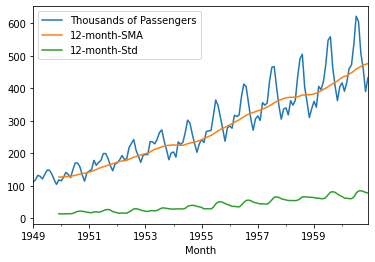

In [4]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

In [5]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(0.8153688792060463,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [6]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
      

In [7]:
print('Augmented Dickey-Fuller Test on Airline Data')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64


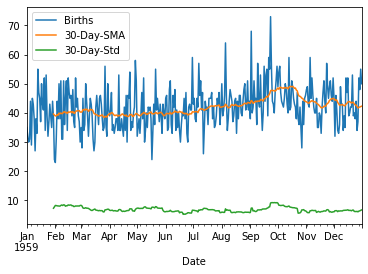

In [8]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-SMA','30-Day-Std']].plot();

In [9]:
print('Augmented Dickey-Fuller Test on Daily Female Births')
dftest = adfuller(df2['Births'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Daily Female Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
dtype: float64


In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df1['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [12]:
adf_test(df2['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


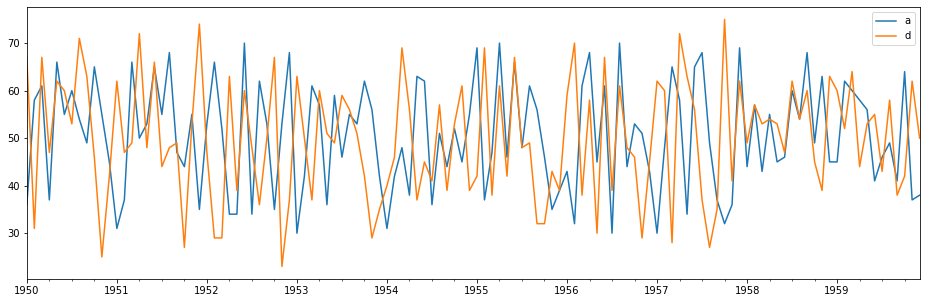

In [13]:
df3 = pd.read_csv('samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3[['a','d']].plot(figsize=(16,5));

In [ ]:
It's hard to tell from this overlay but df['d'] almost perfectly predicts the behavior of df['a'].
To see this more clearly (spoiler alert!), we will shift df['d'] two periods forward.

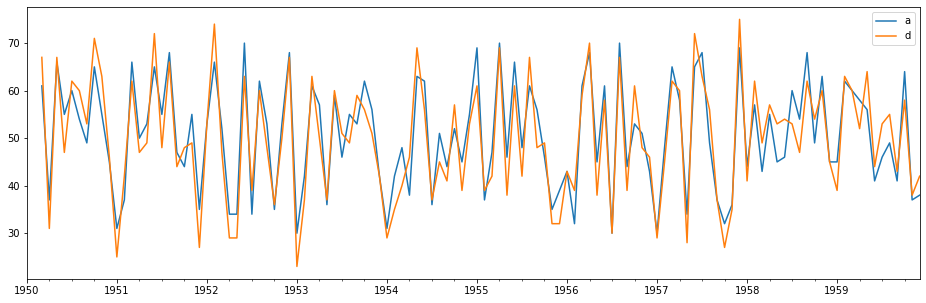

In [14]:
df3['a'].iloc[2:].plot(figsize=(16,5),legend=True);
df3['d'].shift(2).plot(legend=True);

In [ ]:
Run the test
The function takes in a 2D array [y,x] and a maximum number of lags to test on x. Here our y is column 'a' and x is column 'd'. We'll set maxlags to 3.

In [15]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


In [ ]:
Essentially we're looking for extremely low p-values, which we see at lag 2.
By comparison, let's compare two datasets that are not at all similar, 'b' and 'd'.

In [16]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['b','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


Evaluating forecast accuracy
Two calculations related to linear regression are mean squared error (MSE) and root mean squared error (RMSE)

The formula for the mean squared error is

     𝑀𝑆𝐸=1𝐿∑𝑙=1𝐿(𝑦𝑇+𝑙−𝑦̂ 𝑇+𝑙)2 

where  𝑇  is the last observation period and  𝑙  is the lag point up to  𝐿  number of test observations.

The formula for the root mean squared error is

     𝑅𝑀𝑆𝐸=𝑀𝑆𝐸⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√=1𝐿∑𝑙=1𝐿(𝑦𝑇+𝑙−𝑦̂ 𝑇+𝑙)2⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√ 


The advantage of the RMSE is that it is expressed in the same units as the data.


A method similar to the RMSE is the mean absolute error (MAE) which is the mean of the magnitudes of the error, given as


     𝑀𝐴𝐸=1𝐿∑𝑙=1𝐿∣𝑦𝑇+𝑙−𝑦̂ 𝑇+𝑙∣ 


A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

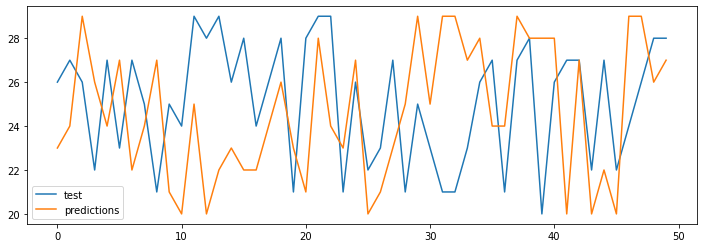

In [17]:
import numpy as np
import pandas as pd
%matplotlib inline
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])
df.plot(figsize=(12,4));

In [18]:
MSE = mse(df['test'],df['predictions'])
RMSE = rmse(df['test'],df['predictions'])
MAE = meanabs(df['test'],df['predictions'])

print(f'Model  MSE: {MSE:.3f}')
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model  MAE: {MAE:.3f}')

Model  MSE: 17.020
Model RMSE: 4.126
Model  MAE: 3.540


In [ ]:
AIC / BIC
More sophisticated tests include the Akaike information criterion (AIC) and the Bayesian information criterion (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

    from from statsmodels.tools.eval_measures import aic, bic

but we seldom compute them alone as they are built into many of the statsmodels tools we use.

In [19]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


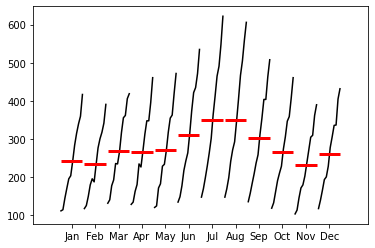

In [20]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df['Thousands of Passengers']);

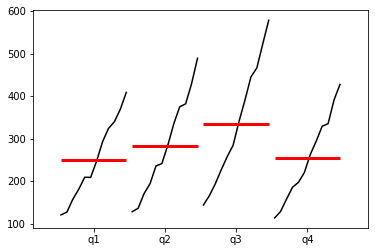

In [21]:
dfq = df['Thousands of Passengers'].resample(rule='Q').mean()

quarter_plot(dfq);

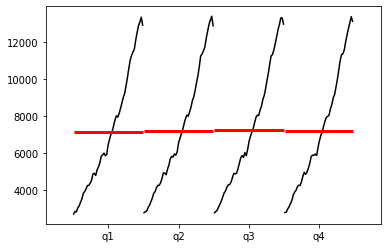

In [23]:
#Let's compare this to our nonseasonal macrodata.csv dataset:
df3 = pd.read_csv('macrodata.csv',index_col=0,parse_dates=True)
quarter_plot(df3['realgdp']);